# Named Entity Identification using SVM

- Here, we will be using a SVM Classifier for NEI task on CoNLL(Conference on Natural Language Learning) dataset with appropriate feature engineering.

In [ ]:
%%capture
!python3 -m pip install datasets

## Collecting the Data

CoNLL NER dataset

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from datasets import load_dataset
data = load_dataset('conllpp')

In [ ]:
data # Understanding the data

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

Let's create train and test data with id, tokens, ner_tags.

In [ ]:
dataset = {
    'train' : [{'id':x['id'],'tokens':x['tokens'],'ner_tags':x['ner_tags']} for x in data['train']],
    'test': [{'id':x['id'],'tokens':x['tokens'],'ner_tags':x['ner_tags']} for x in data['test']]
}
train_data = dataset['train']
test_data = dataset['test']
# Example
print(train_data[0])
print(test_data[0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}
{'id': '0', 'tokens': ['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.'], 'ner_tags': [0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]}


**train_data** and **test_data** consists of dictionary of sentences, each sentence has it's id, tokens and ner_tags.

In [ ]:
train_size = len(dataset['train'])
test_size = len(dataset['test'])
print(train_size,test_size)

14041 3453


# Data Exploration

To analyze the skewness of entity distribution in sentences, calculate the percentage of words that are entities, and visualize the distribution of these percentages.

- **percentage_dict** stores the count of sentences in the training data for each percentage of entity words, ranging from 0 to 100.

- **percentage_indices** stores the indices of the sentences in the training data for each percentage of entity words.

In [ ]:
percentage_dict = [0 for i in range(101)]
percentage_indices = [[] for i in range(101)]
for s in train_data:
  tags = s['ner_tags']
  num_entities = len(tags) - tags.count(0)
  percentage_entities = int((num_entities/len(tags))*100)
  percentage_dict[percentage_entities] += 1
  percentage_indices[percentage_entities].append(int(s['id']))

### Visualization

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

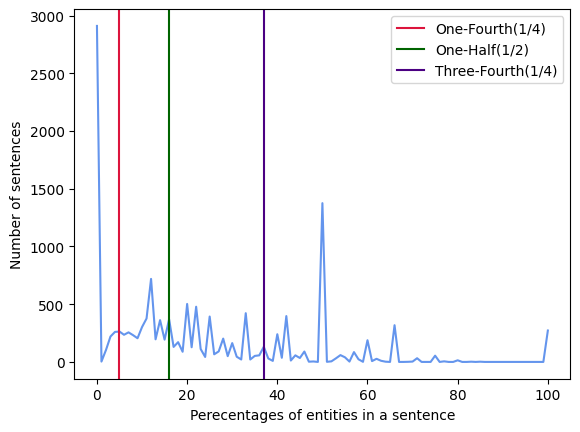

In [ ]:
total_sentences = sum(percentage_dict)
sentences_count = 0
one_fourth = half = three_fourth = 0
for i in range(101):
  sentences_count += percentage_dict[i]
  if not three_fourth:
    if sentences_count > total_sentences*(3/4):
      three_fourth = i
    if not half:
      if sentences_count > total_sentences*(2/4):
        half = i
      if not one_fourth:
        if sentences_count > total_sentences*(1/4):
          one_fourth = i

plt.plot(percentage_dict,color='#6495ED')
plt.axvline(x=one_fourth,label='One-Fourth(1/4)',color='#DC143C')
plt.axvline(x=half,label='One-Half(1/2)',color='#006400')
plt.axvline(x=three_fourth,label='Three-Fourth(1/4)',color='#4B0082')
plt.xlabel('Perecentages of entities in a sentence')
plt.ylabel('Number of sentences')
plt.legend()

In [ ]:
print(f"Number of sentences with more than 25% of words as entities are {sum(percentage_dict[25:])}")
print(f"Number of sentences with more than 50% of words as entities are {sum(percentage_dict[50:])}")
print(f"Number of sentences with more than 75% of words as entities are {sum(percentage_dict[75:])}")

Number of sentences with more than 25% of words as entities are 5185
Number of sentences with more than 50% of words as entities are 2560
Number of sentences with more than 75% of words as entities are 349


# Data Augmentation

For normalising the training data, lets append more sentences at the end of the training data with large number of entities as words. From the above results, we can see that number of senteneces with more than 50% words as entities are 2560, which is very less. So, lets append these sentences twice to the training data to overcome the problem of skewedness.

Therefore, number of sentences in the training data are (14041 + 5120) out of which 7680 sentences have more than 50% words as entities.

**Do not run the cells in this Section to get the results without Data Augmentation.**

In [ ]:
final_index = len(train_data) - 1
for i in range(50,101):
  for j in percentage_indices[i]:
    final_index += 1
    sent = {'id':final_index,'tokens':train_data[j]['tokens'],'ner_tags':train_data[j]['ner_tags']}
    train_data.append(sent)
    final_index += 1
    sent = {'id':final_index,'tokens':train_data[j]['tokens'],'ner_tags':train_data[j]['ner_tags']}
    train_data.append(sent)
print(len(train_data))

19161


In [ ]:
train_data[len(train_data)-1000]

{'id': 18161, 'tokens': ['BOSTON', 'AT', 'CALIFORNIA'], 'ner_tags': [3, 0, 5]}

# Feature Extraction

In [ ]:
%%capture
import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize # Tokenize the words in a sentence
nltk.download('punkt') # Unsupervised learning model to train the unlabeled data
nltk.download('averaged_perceptron_tagger') # It contains the pre trained POS tagger in nltk

[Here]("https://docs.google.com/document/d/1Gwg8rcCAIPv1FrRMC13OU1zDny625nmNqhKUUA37e4w/edit?usp=sharing") is the list of all POS Tags in nltk.

In [ ]:
# Example
tokens = word_tokenize("I have three best friends in my B.Tech.")
tags = pos_tag(tokens)
print(tags)
print(tokens)

[('I', 'PRP'), ('have', 'VBP'), ('three', 'CD'), ('best', 'JJS'), ('friends', 'NNS'), ('in', 'IN'), ('my', 'PRP$'), ('B.Tech', 'NNP'), ('.', '.')]
['I', 'have', 'three', 'best', 'friends', 'in', 'my', 'B.Tech', '.']


### Input format to the function **wordToFeature**

- **sentence** : List of all words in a sentence
  - Example : ['I', 'have', 'three', 'best', 'friends', 'in', 'my', 'B.Tech', '.']
- **pos_tags** : List of POS Tags corresponding to the words given in the sentence.
  - Example : ['PRP', 'VBP', 'CD', 'JJS', 'NNS', 'IN', 'PRP$', 'NNP', '.']
- **i** : Index of the word in a sentence


In [ ]:
def wordToFeature(sentence,pos_tags,i):
  postag = pos_tags[i]
  word = sentence[i]
  lword = word.lower()
  features = {
      'postag'  : str(postag),
      'istitle' : word.istitle(),
      'isupper' : word.isupper(),
      'length'  : len(word),
      'isdigit' : word.isdigit(),
      '1suffix' : lword[-1:],
      '2suffix' : lword[-2:],
      '3suffix' : lword[-3:],
      '4suffix' : lword[-4:],
      '1prefix' : lword[:1],
      '2prefix' : lword[:2],
      '3prefix' : lword[:3],
      '4prefix' : lword[:4]
  }
  if i > 0:
    prevWord = sentence[i-1]
    prevpostag = pos_tags[i-1]
    features.update({
        'prevpostag'  : prevpostag,
        'previsupper' : prevWord.isupper(),
        'previstitle' : prevWord.istitle(),
        'prevdigit'   : prevWord.isdigit(),
        'begin'       : False
    })
  else:
    features.update({'begin' : True})
  if i < len(sentence) - 1:
    nextWord = sentence[i+1]
    nextpostag = pos_tags[i+1]
    features.update({
        'nextpostag'  : nextpostag,
        'nextisupper' : nextWord.isupper(),
        'nextistitle' : nextWord.istitle(),
        'nextdigit'   : nextWord.isdigit(),
        'end'         : False
    })
  else:
    features.update({'end' : True})
  return features

In [ ]:
example_sentence = "I have three best friends in my B.Tech."
tokens = word_tokenize(example_sentence)
postags = [i[1] for i in pos_tag(tokens)]
print(wordToFeature(tokens,postags,3))

{'postag': 'JJS', 'istitle': False, 'isupper': False, 'length': 4, 'isdigit': False, '1suffix': 't', '2suffix': 'st', '3suffix': 'est', '4suffix': 'best', '1prefix': 'b', '2prefix': 'be', '3prefix': 'bes', '4prefix': 'best', 'prevpostag': 'CD', 'previsupper': False, 'previstitle': False, 'prevdigit': False, 'begin': False, 'nextpostag': 'NNS', 'nextisupper': False, 'nextistitle': False, 'nextdigit': False, 'end': False}


### Sentence to feature function

It returns the list of features of all words in a sentence.

Input format for **s**: {'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [ ]:
def sentenceToFeature(s):
  pos_tags = [i[1] for i in pos_tag(s['tokens'])]
  k = [(wordToFeature(s['tokens'],pos_tags,i)) for i in range(len(s['tokens']))]
  return k

### Word to bool function

It returns 1 if the word's ner_tag is positive, else it returns 0.

In [ ]:
def wordTobool(s,i):
  if s['ner_tags'][i] > 0:
    return 1
  return 0

In [ ]:
print(len(dataset['train']))
print(len(dataset['test']))
print(dataset['train'][0])

19161
3453
{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


## Training and Testing the Data

- **X_train** and **X_test** consists of features of all words in the dataset.

- **Y_train** and **Y_test** consists of NEI Tag corresponding to the words in X. Basically, it consists of binary values.

In [ ]:
X_train,Y_train = [],[]
X_test,Y_test = [],[]
for s in dataset['train']:
  pos_tags = [i[1] for i in pos_tag(s['tokens'])]
  for i in range(len(s['tokens'])):
    X_train.append(wordToFeature(s['tokens'],pos_tags,i))
    Y_train.append(wordTobool(s,i))
for s in dataset['test']:
  pos_tags = [i[1] for i in pos_tag(s['tokens'])]
  for i in range(len(s['tokens'])):
    X_test.append(wordToFeature(s['tokens'],pos_tags,i))
    Y_test.append(wordTobool(s,i))

In [ ]:
print(len(X_train))
print(len(X_test))

229171
46435


### Without Data Augmentation

- Number of samples in the Training data are 203621.
- Number of samples in the Testing data are 46435.



### With Data Augmentation

- Number of samples in the Training data are 229171.
- Number of samples in the Testing data are 46435.

In [ ]:
# Example
print(X_train[0]) # Features of the word 'EU'
print(Y_train[0]) # NEI Tag

{'postag': 'NNP', 'istitle': False, 'isupper': True, 'length': 2, 'isdigit': False, '1suffix': 'u', '2suffix': 'eu', '3suffix': 'eu', '4suffix': 'eu', '1prefix': 'e', '2prefix': 'eu', '3prefix': 'eu', '4prefix': 'eu', 'begin': True, 'nextpostag': 'VBZ', 'nextisupper': False, 'nextistitle': False, 'nextdigit': False, 'end': False}
1


### DictVectorizer

- This transformer turns lists of mappings (dict-like objects) of feature names to feature values into NumPy arrays.

In [ ]:
from sklearn.feature_extraction import DictVectorizer
vector = DictVectorizer()
r = vector.fit_transform(X_train + X_test)
Xtrain = r[:len(X_train)]
Xtest = r[len(X_train):]

In [ ]:
# Example
print(Xtrain[0])

  (0, 36)	1.0
  (0, 109)	1.0
  (0, 488)	1.0
  (0, 1303)	1.0
  (0, 4170)	1.0
  (0, 8929)	1.0
  (0, 17302)	1.0
  (0, 29239)	1.0
  (0, 35327)	1.0
  (0, 35328)	0.0
  (0, 35329)	0.0
  (0, 35330)	0.0
  (0, 35331)	1.0
  (0, 35332)	2.0
  (0, 35333)	0.0
  (0, 35334)	0.0
  (0, 35335)	0.0
  (0, 35373)	1.0
  (0, 35397)	1.0


## SVM Classifier

### Without Data Augmentation
- Time taken to train the model and predict the tags for test data: 25m + 2m.

### With Data Augmentation
- Time taken to train the model and predict the tags for test data: 1h 2m + 2m.

In [ ]:
from sklearn.svm import SVC
model = SVC()
model.fit(Xtrain,Y_train)
Y_pred = model.predict(Xtest)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix
accuracy = accuracy_score(Y_test,Y_pred)
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
f1score = (2*precision*recall)/(precision+recall)
confusion = confusion_matrix(Y_test,Y_pred)

In [ ]:
print("Accuracy Score   : ",accuracy)
print("Precision Score  : ",precision)
print("Recall Score     : ",recall)
print("F1 Score         : ",f1score)

Accuracy Score   :  0.9839345321417035
Precision Score  :  0.9460807600950119
Recall Score     :  0.9646403487527246
F1 Score         :  0.9552704161170403


## Summary

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Parameter','Without Data Augmentation', 'With Data Augmentation']
table.add_rows(
    [
        ["Accuracy Score",0.9837191773446754,0.9839345321417035],
        ["Precision Score",0.9483624193162802,0.9460807600950119],
        ["Recall Score",0.9607653184790507,0.9646403487527246],
        ["F1 Score",0.9545235803657364,0.9552704161170403]
    ]
)
print(table)

+-----------------+---------------------------+------------------------+
|    Parameter    | Without Data Augmentation | With Data Augmentation |
+-----------------+---------------------------+------------------------+
|  Accuracy Score |     0.9837191773446754    |   0.9839345321417035   |
| Precision Score |     0.9483624193162802    |   0.9460807600950119   |
|   Recall Score  |     0.9607653184790507    |   0.9646403487527246   |
|     F1 Score    |     0.9545235803657364    |   0.9552704161170403   |
+-----------------+---------------------------+------------------------+


### Confusion Matrix for the model without data augmentation

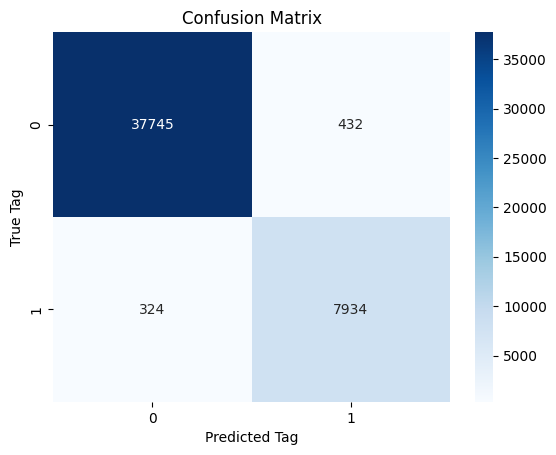

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion,annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Tag')
plt.ylabel('True Tag')
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix for the model with data augmentation

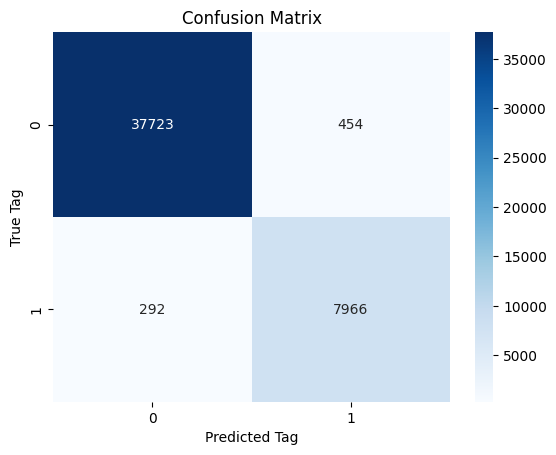

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion,annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Tag')
plt.ylabel('True Tag')
plt.title('Confusion Matrix')
plt.show()

# Named Entity Identifier

- It identifies the entities in a given sentence from the model (data augmented model) trained above.

In [ ]:
def identify_entities(sentence):
  global model,vector
  tokens = word_tokenize(sentence)
  postags = [i[1] for i in pos_tag(tokens)]
  test_example = []
  for i in range(len(tokens)):
    test_example.append(vector.transform(wordToFeature(tokens,postags,i)))
  pred = [(tokens[i],model.predict(test_example[i])[0]) for i in range(len(test_example))]
  return pred

In [ ]:
identify_entities("I live in Warangal.")

[('I', 0), ('live', 0), ('in', 0), ('Warangal', 1), ('.', 0)]

In [ ]:
identify_entities("I have three friends Sahithi, Manaswini and Varun Teja.")

[('I', 0),
 ('have', 0),
 ('three', 0),
 ('friends', 0),
 ('Sahithi', 1),
 (',', 0),
 ('Manaswini', 1),
 ('and', 0),
 ('Varun', 1),
 ('Teja', 1),
 ('.', 0)]

In [ ]:
identify_entities("I would like to end up this Named Entity Indentification project with this last example!")

[('I', 0),
 ('would', 0),
 ('like', 0),
 ('to', 0),
 ('end', 0),
 ('up', 0),
 ('this', 0),
 ('Named', 0),
 ('Entity', 1),
 ('Indentification', 1),
 ('project', 0),
 ('with', 0),
 ('this', 0),
 ('last', 0),
 ('example', 0),
 ('!', 0)]